## Setup 

load initial packages and df

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# set seed
np.random.seed(2)

# read in data
df = pd.read_csv('cleaned_data.csv')

# list all column names without ...
pd.set_option('display.max_columns', None)

##### handle prepocessing #####
initial_dat = df

# Drop all rows with NA
initial_dat = initial_dat.dropna(subset=['Report Year','Total Persons Injured','Railroad Employees Injured','Passengers Injured','Others Injured'])

# Convert Report Year to int
initial_dat['Year'] = initial_dat['Report Year'].astype(int)
initial_dat = initial_dat.drop('Report Year', axis=1)

# Convert Date to Datetime
initial_dat = initial_dat.dropna(subset=['Date'])
initial_dat['date'] = pd.to_datetime(initial_dat['Date'])
initial_dat = initial_dat.drop('Date',axis=1)

# new time features based on datetime var/index
initial_dat['dayofweek'] = initial_dat['date'].dt.dayofweek.astype(int)
initial_dat['month'] = initial_dat['date'].dt.month.astype(int)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (20,32,33,41,42,43,44,45,46,47,48,49,50,105,106,111) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
initial_dat['Track Class'] = initial_dat['Track Class'].replace({0.0:0,
                                    1.0:'1',
                                    2.0:'2',
                                    3.0:'3',
                                    4.0:'4',
                                    5.0:'5',
                                    6.0:'6',
                                    'O':'0',
                                    '.':'0'})
initial_dat['Track Class'].value_counts()

1    115897
2     28818
4     24732
3     24408
5      4967
X      4202
6       731
7       180
8        72
0        24
9        13
0        10
Name: Track Class, dtype: int64

preprocessing for model

In [44]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

#removing the year 2003 due to errors
initial_dat = initial_dat[initial_dat['Year'] != 2003]
print(initial_dat[initial_dat['Year'] == 2003])

initial_dat = initial_dat[initial_dat['Equipment Attended'] != '7']
initial_dat = initial_dat[initial_dat['Equipment Attended'] != '0']
initial_dat[initial_dat['Equipment Attended']=='7']
print(initial_dat['Equipment Attended'].value_counts())

cat_features = initial_dat[initial_dat['Year']>1999].loc[:,
        ['Reporting Railroad Name',
        'Accident Type',
        'Equipment Type',
        'Equipment Attended',
        'Method of Operation',
        'Passengers Transported',
        'Primary Accident Cause Code',
        'Accident Cause Code',
        'Track Class',
        'Reporting Railroad Class',
        'First Car Loaded',
        'Causing Car Loaded',
        'Time',
        'Visibility',
        'Weather Condition',
        'Maintenance Railroad Name']]

num_features = initial_dat[initial_dat['Year']>1999].select_dtypes(include=['float64', 'int64'])
num_features = num_features.drop(['Accident Year',
                   'Accident Month',
                   'Other Accident Year',
                   'Other Accident Month',
                   'Day',
                   'Maintenance Accident Year',
                   'Maintenance Accident Month',
                   'Railroad Employees Killed',
                   'Passengers Killed',
                   'Passengers Injured',
                   'Others Killed',
                   'Others Injured',
                   'Total Persons Killed',
                   'Total Persons Injured',
                   'Total Killed Form 54',
                   'Total Injured Form 54',
                   'Persons Killed For Reporting Railroad',
                   'Persons Injured For Reporting Railroad'], axis=1)


imputer = SimpleImputer(strategy='mean')
imputed = imputer.fit_transform(num_features)
oe_encoder = OrdinalEncoder()
oe = oe_encoder.fit_transform(cat_features)


#cat = pd.DataFrame.sparse.from_spmatrix(ohe, columns=ohe_encoder.get_feature_names_out())
num = pd.DataFrame(imputed, columns=imputer.feature_names_in_)
cat = pd.DataFrame(oe, columns=oe_encoder.feature_names_in_)

model_dat = pd.concat([num,cat],axis=1)

model_dat.fillna(-1, inplace=True)


Empty DataFrame
Columns: [Reporting Railroad Name, Accident Year, Accident Month, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Name, Maintenance Accident Year, Maintenance Accident Month, Grade Crossing ID, Day, Time, Accident Type, Hazmat Cars, Hazmat Cars Damaged, Hazmat Released Cars, Persons Evacuated, Subdivision, Division, Station, Milepost, State Abbreviation, County Name, District, Temperature, Visibility, Weather Condition, Track Type, Track Name, Track Class, Track Density, Train Direction, Equipment Type, Equipment Attended, Train Speed, Recorded Estimated Speed, Maximum Speed, Gross Tonnage, Signalization, Method of Operation, Adjunct Code 1, Adjunct Code Name 1, Adjunct Code 2, Adjunct Code Name 2, Adjunct Code 3, Adjunct Code Name 3, Remote Control Locomotive, First Car Number, First Car Position, First Car Loaded, Causing Car Initials, Causing Car Number, Causing Car Position, Causing Car Loaded, Positive Alc

## Creating Model

### Split Data (Training/Testing)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_absolute_error

X = model_dat.drop('Railroad Employees Injured',axis=1)
y = model_dat['Railroad Employees Injured']
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.4)

print("X-train shape: ", xtrain.shape)
print("Y-train shape: ", ytrain.shape)
print("X-test shape: ", xtest.shape)
print("Y-test shape: ", ytest.shape)


X-train shape:  (40276, 67)
Y-train shape:  (40276,)
X-test shape:  (26852, 67)
Y-test shape:  (26852,)


### Test Model Hyperparams

n_estimators

In [82]:
from sklearn.metrics import mean_squared_error

estimators = np.array([10,20,30,40,50,75,100,150])
train_error = np.array([])
train_score = np.array([])
test_error = np.array([])
test_score = np.array([])

for i in estimators:
    rfreg_test = RandomForestRegressor(max_features='sqrt',
                                       n_estimators=i,
                                       n_jobs=-1,
                                       verbose=False,
                                       random_state=0)
    rfreg_test.fit(xtrain,ytrain)
    train_score = np.append(train_score,rfreg_test.score(xtrain,ytrain))
    test_score = np.append(test_score,rfreg_test.score(xtest,ytest))
    train_error = np.append(train_error,mean_squared_error(ytrain,rfreg_test.predict(xtrain)))
    test_error = np.append(test_error,mean_squared_error(ytest,rfreg_test.predict(xtest)))

error_data = pd.DataFrame({'n_estimators':estimators, 'train error':train_error, 'test error':test_error})
score_data = pd.DataFrame({'n_estimators':estimators, 'train score':train_score, 'test score':test_score})

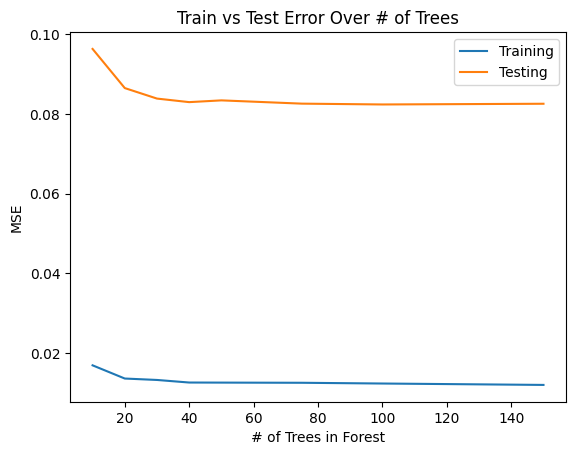

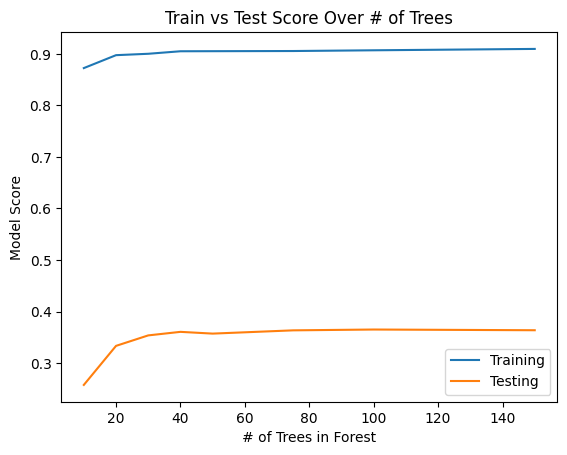

In [84]:
plt.plot(error_data['n_estimators'],error_data['train error'], label="Training")
plt.plot(error_data['n_estimators'],error_data['test error'], label="Testing")
plt.xlabel("# of Trees in Forest")
plt.ylabel("MSE")
plt.title("Train vs Test Error Over # of Trees")
plt.legend()
plt.savefig("images/rf-max_feat-error.png")
plt.show()

plt.plot('n_estimators','train score',data=score_data, label="Training")
plt.plot('n_estimators','test score',data=score_data, label="Testing")
plt.xlabel("# of Trees in Forest")
plt.ylabel("Model Score")
plt.title("Train vs Test Score Over # of Trees")
plt.legend()
plt.savefig("images/rf-max_feat-score.png")
plt.show()

criterion

In [93]:
crit = pd.Series(['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])
train_error = np.array([])
train_score = np.array([])
test_error = np.array([])
test_score = np.array([])

for i in crit:
    rfreg_test = RandomForestRegressor(max_features='sqrt',
                                       n_estimators=50,
                                       criterion=i,
                                       n_jobs=-1,
                                       verbose=False,
                                       random_state=0)
    rfreg_test.fit(xtrain,ytrain)
    train_score = np.append(train_score,rfreg_test.score(xtrain,ytrain))
    test_score = np.append(test_score,rfreg_test.score(xtest,ytest))
    train_error = np.append(train_error,mean_squared_error(ytrain,rfreg_test.predict(xtrain)))
    test_error = np.append(test_error,mean_squared_error(ytest,rfreg_test.predict(xtest)))

error_data = pd.DataFrame({'criterion':crit, 'train error':train_error, 'test error':test_error})
score_data = pd.DataFrame({'criterion':crit, 'train score':train_score, 'test score':test_score})


In [97]:
error_data

,criterion,train error,test error
0,squared_error,0.012518,0.083444
1,absolute_error,0.012770,0.089182
2,friedman_mse,0.012461,0.083831
3,poisson,0.035012,0.088894


No handles with labels found to put in legend.


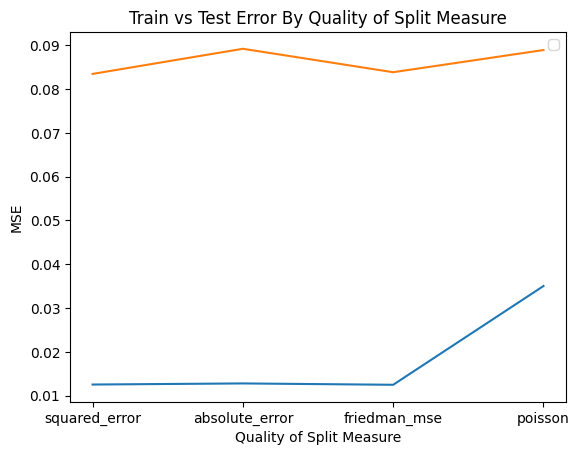

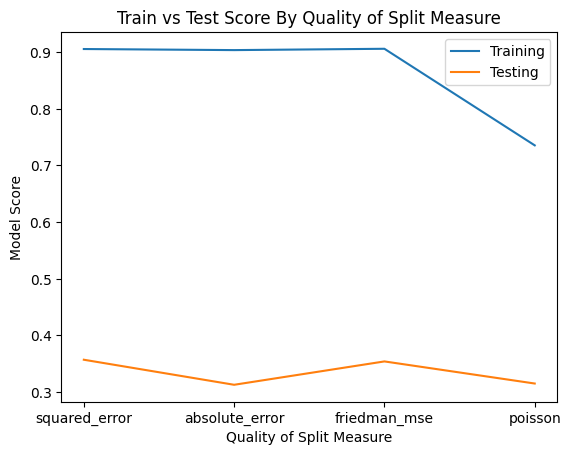

In [98]:
plt.plot(error_data['criterion'],error_data['train error'])
plt.plot(error_data['criterion'],error_data['test error'])
plt.xlabel("Quality of Split Measure")
plt.ylabel("MSE")
plt.title("Train vs Test Error By Quality of Split Measure")
plt.legend()
plt.savefig("images/rf-criterion-error.png")
plt.show()

plt.plot('criterion','train score',data=score_data, label="Training")
plt.plot('criterion','test score',data=score_data, label="Testing")
plt.xlabel("Quality of Split Measure")
plt.ylabel("Model Score")
plt.title("Train vs Test Score By Quality of Split Measure")
plt.legend()
plt.savefig("images/rf-criterion-score.png")
plt.show()

max_depth

In [89]:
depth = pd.Series([1,2,4,6,8,10,15,20,100])
#estimators = np.array([10,20,30,40,50,75,100,150])
train_error = np.array([])
train_score = np.array([])
test_error = np.array([])
test_score = np.array([])

for i in depth:
    rfreg_test = RandomForestRegressor(max_features='sqrt',
                                       n_estimators=50,
                                       max_depth=i,
                                       n_jobs=-1,
                                       verbose=False,
                                       random_state=0)
    rfreg_test.fit(xtrain,ytrain)
    train_score = np.append(train_score,rfreg_test.score(xtrain,ytrain))
    test_score = np.append(test_score,rfreg_test.score(xtest,ytest))
    train_error = np.append(train_error,mean_squared_error(ytrain,rfreg_test.predict(xtrain)))
    test_error = np.append(test_error,mean_squared_error(ytest,rfreg_test.predict(xtest)))

error_data = pd.DataFrame({'max_depth':depth, 'train error':train_error, 'test error':test_error})
score_data = pd.DataFrame({'max_depth':depth, 'train score':train_score, 'test score':test_score})


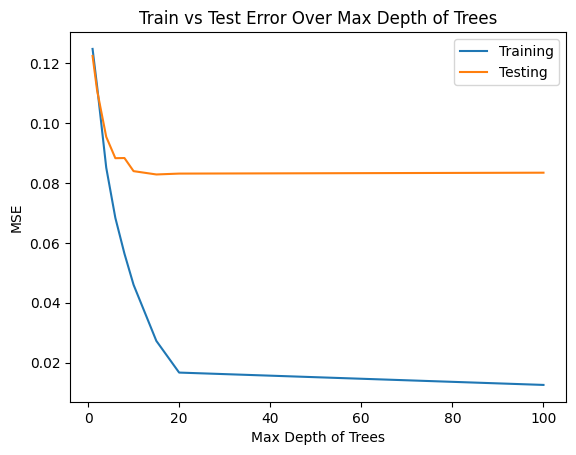

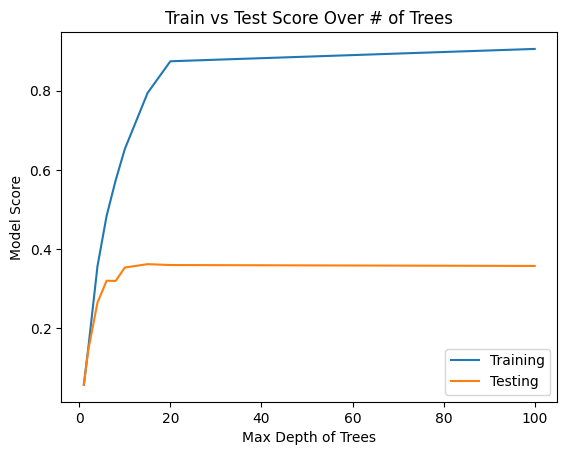

In [92]:
plt.plot(error_data['max_depth'],error_data['train error'], label="Training")
plt.plot(error_data['max_depth'],error_data['test error'], label="Testing")
plt.xlabel("Max Depth of Trees")
plt.ylabel("MSE")
plt.title("Train vs Test Error Over Max Depth of Trees")
plt.legend()
plt.savefig("images/rf-max_depth-error.png")
plt.show()

plt.plot('max_depth','train score',data=score_data, label="Training")
plt.plot('max_depth','test score',data=score_data, label="Testing")
plt.xlabel("Max Depth of Trees")
plt.ylabel("Model Score")
plt.title("Train vs Test Score Over # of Trees")
plt.legend()
plt.savefig("images/rf-max_depth-score.png")
plt.show()

### Build and Fit RF Model

In [108]:
rfreg = RandomForestRegressor(max_features='sqrt',
                              n_estimators=50,
                              max_depth=40,
                              n_jobs=-1,
                              random_state=0)

rfreg.fit(xtrain, ytrain)
rf_score = rfreg.score(xtest,ytest)
rf_pred = rfreg.predict(xtest)
rf_mae = mean_absolute_error(ytest,rf_pred)

print("score:",rf_score)
print("MAE:",rf_mae)

score: 0.3597044999977964
MAE: 0.07085840905705348


#### Analyze Model

feature importances

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


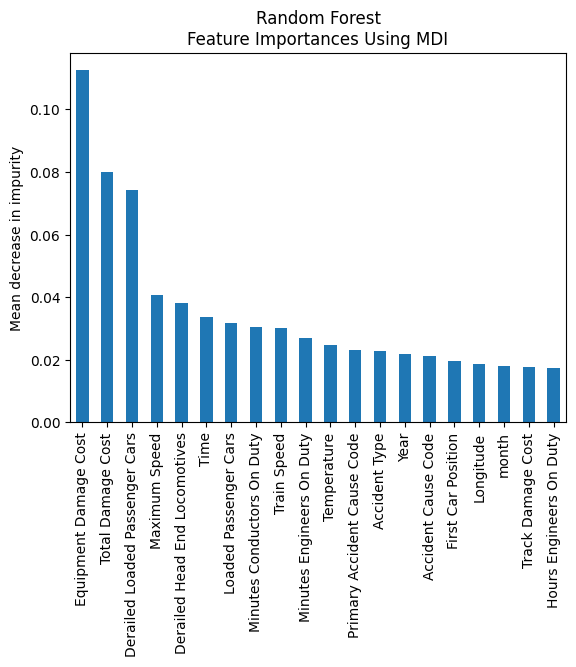

In [109]:
importances = rfreg.feature_importances_
colnames = X.columns

std = np.std([tree.feature_importances_ for tree in rfreg.estimators_], axis=0)
forest_importances = pd.DataFrame({'importances':importances,'std':std}, index=colnames)
forest_importances.sort_values('importances',ascending=False)

top_20 = forest_importances.sort_values('importances',ascending=False).iloc[0:20,0]
std = forest_importances.sort_values('importances',ascending=False).iloc[0:20,1]
fig, ax = plt.subplots()
top_20.plot.bar(ax=ax)
ax.set_title("Random Forest\nFeature Importances Using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.savefig("images/rf-injury-feature-importance.png")
fig.show()

predictions visualized

In [110]:
pred_data = pd.concat([model_dat['Year'].astype(int),pd.Series(ytest),pd.Series(rf_pred)],axis=1)
pred_data['prediction'] = pred_data.iloc[:,2]
pred_data['injuries'] = pred_data.iloc[:,1]
pred_data = pd.DataFrame(pred_data.iloc[:,[0,3,4]])

inj_yr = pred_data.groupby('Year')['injuries'].sum().reset_index()
pred_yr = pred_data.groupby('Year')['prediction'].sum().reset_index()

In [111]:
pd.concat([inj_yr,pred_yr],axis=1)

,Year,injuries,Year,prediction
0,2000,93.0,2000,25.683333
1,2001,103.0,2001,36.720000
2,2002,82.0,2002,193.610000
3,2004,93.0,2004,0.000000
4,2005,79.0,2005,24.980000
5,2006,64.0,2006,42.180000
6,2007,52.0,2007,45.380000
7,2008,58.0,2008,32.440000
8,2009,39.0,2009,8.980000
9,2010,52.0,2010,89.360000


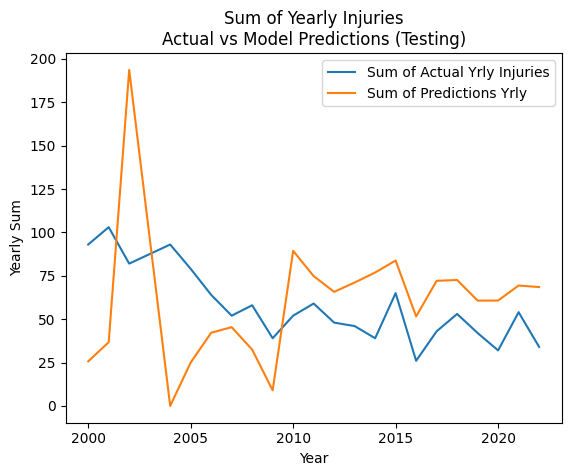

In [112]:
plt.plot('Year','injuries', data=inj_yr, label='Sum of Actual Yrly Injuries')
plt.plot('Year','prediction', data=pred_yr, label='Sum of Predictions Yrly')
plt.xlabel('Year')
plt.ylabel('Yearly Sum')
plt.title('Sum of Yearly Injuries\nActual vs Model Predictions (Testing)')
plt.legend()
plt.savefig("images/rf-pred-vs-actual-test.png")
plt.show()

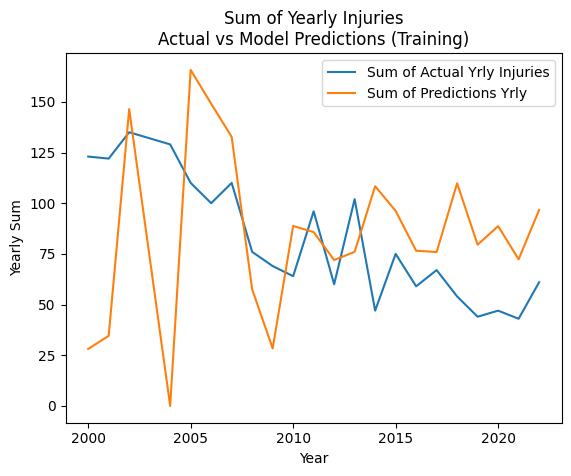

In [113]:
train_pred = rfreg.predict(xtrain)
pred_data = pd.concat([model_dat['Year'].astype(int),pd.Series(ytrain),pd.Series(train_pred)],axis=1)
pred_data['prediction'] = pred_data.iloc[:,2]
pred_data['injuries'] = pred_data.iloc[:,1]
pred_data = pd.DataFrame(pred_data.iloc[:,[0,3,4]])

inj_yr = pred_data.groupby('Year')['injuries'].sum().reset_index()
pred_yr = pred_data.groupby('Year')['prediction'].sum().reset_index()

plt.plot('Year','injuries', data=inj_yr, label='Sum of Actual Yrly Injuries')
plt.plot('Year','prediction', data=pred_yr, label='Sum of Predictions Yrly')
plt.xlabel('Year')
plt.ylabel('Yearly Sum')
plt.title('Sum of Yearly Injuries\nActual vs Model Predictions (Training)')
plt.legend()
plt.savefig("images/rf-pred-vs-actual-train.png")
plt.show()

### Use Cross Validation

In [114]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

cv = cross_validate(rfreg,X,y,cv=5,return_train_score=True,n_jobs=-1)
cv_pred = cross_val_predict(rfreg,X,y,cv=5, n_jobs=-1)

In [115]:
cv.keys()
cv['test_score']

array([0.27625185, 0.39112745, 0.38607375, 0.31350966, 0.39311257])

In [116]:
cv_pred_data = pd.concat([model_dat['Year'].astype(int),pd.Series(y),pd.Series(cv_pred)],axis=1)
cv_pred_data['prediction'] = cv_pred_data.iloc[:,2]
cv_pred_data['injuries'] = cv_pred_data.iloc[:,1]
cv_pred_data = pd.DataFrame(cv_pred_data.iloc[:,[0,3,4]])

cv_inj_yr = cv_pred_data.groupby('Year')['injuries'].sum().reset_index()
cv_pred_yr = cv_pred_data.groupby('Year')['prediction'].sum().reset_index()

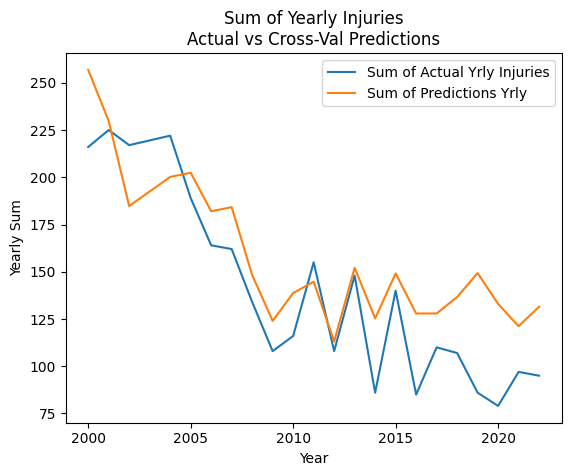

In [117]:
plt.plot('Year','injuries', data=cv_inj_yr, label='Sum of Actual Yrly Injuries')
plt.plot('Year','prediction', data=cv_pred_yr, label='Sum of Predictions Yrly')
plt.xlabel('Year')
plt.ylabel('Yearly Sum')
plt.title('Sum of Yearly Injuries\nActual vs Cross-Val Predictions')
plt.legend()
plt.savefig("images/cv-pred-vs-actual.png")
plt.show()

## Post Model Visualizations

In [118]:
rf_viz_df = {'rf_pred':rf_pred, 'actual':ytest}
cv_viz_df = {'cv_pred':cv_pred, 'actual':y}
cv_viz_df = pd.DataFrame(cv_viz_df)
cv_viz_df = pd.concat([cv_viz_df,X.loc[:,['Equipment Damage Cost','Derailed Loaded Passenger Cars','Train Speed','Accident Type','Temperature','Minutes Conductors On Duty','Minutes Engineers On Duty']]],axis=1)
cv_viz_df

,cv_pred,actual,Equipment Damage Cost,Derailed Loaded Passenger Cars,Train Speed,Accident Type,Temperature,Minutes Conductors On Duty,Minutes Engineers On Duty
0,0.00,0.0,36200.0,0.0,6.0,1.0,60.0,40.000000,40.00000
1,0.00,0.0,4000.0,0.0,4.0,1.0,60.0,40.000000,40.00000
2,0.02,0.0,1320.0,0.0,0.0,12.0,65.0,1.000000,29.77983
3,0.00,0.0,29609.0,0.0,1.0,12.0,65.0,29.847509,29.77983
4,0.14,0.0,17000.0,0.0,3.0,5.0,30.0,29.847509,15.00000
...,...,...,...,...,...,...,...,...,...
67123,0.06,0.0,300000.0,0.0,25.0,1.0,28.0,29.847509,15.00000
67124,0.00,0.0,20000.0,0.0,7.0,1.0,30.0,5.000000,5.00000
67125,0.08,0.0,20000.0,0.0,24.0,1.0,20.0,55.000000,55.00000
67126,0.00,0.0,9000.0,0.0,7.0,1.0,27.0,29.847509,29.77983


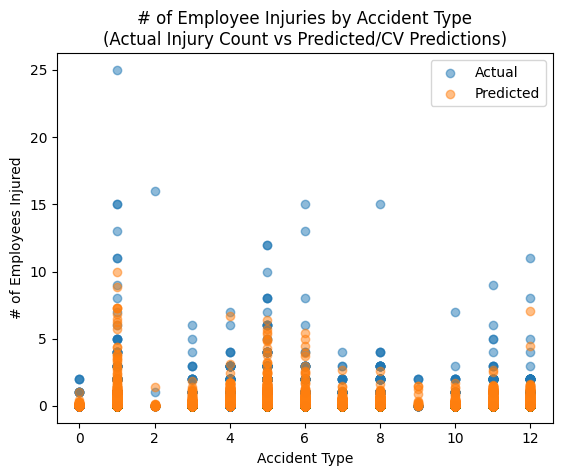

In [80]:
plt.scatter('Accident Type','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter(cv_viz_df['Accident Type'],'cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Accident Type')
#plt.xticks(initial_dat['Accident Type'].unique())
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Accident Type\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()


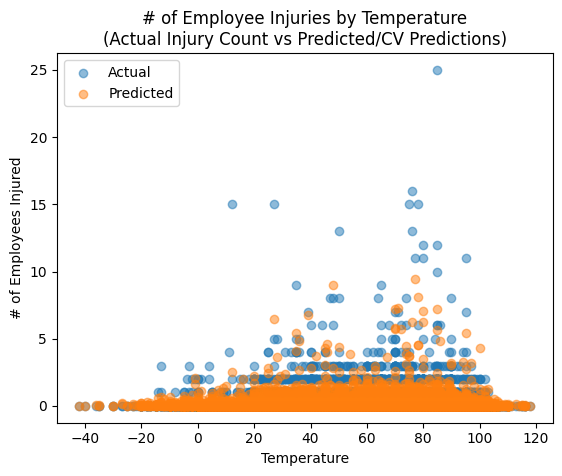

In [119]:
plt.scatter('Temperature','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter(cv_viz_df['Temperature'],'cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Temperature')
#plt.xticks(initial_dat['Accident Type'].unique())
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Temperature\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()

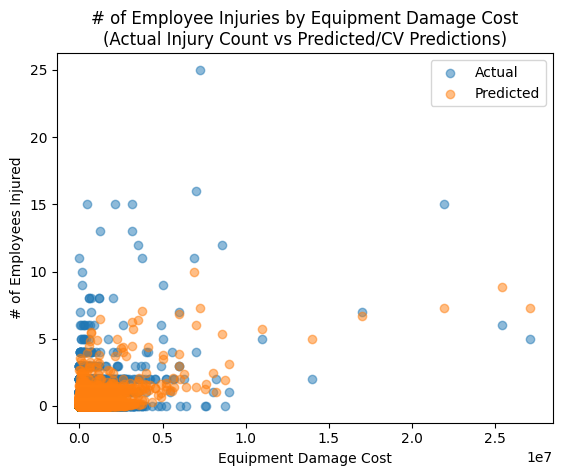

In [74]:
plt.scatter('Equipment Damage Cost','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter('Equipment Damage Cost','cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Equipment Damage Cost')
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Equipment Damage Cost\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()

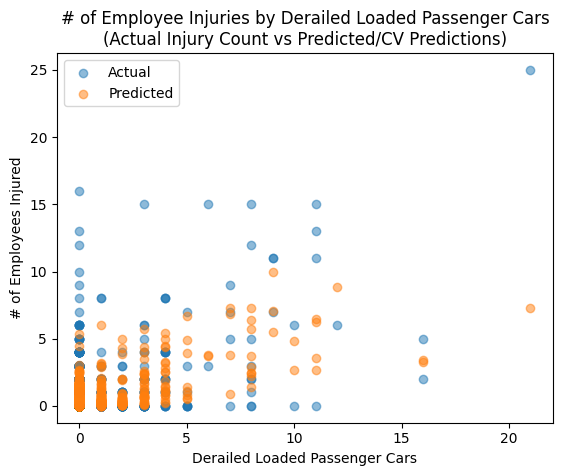

In [75]:
plt.scatter('Derailed Loaded Passenger Cars','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter('Derailed Loaded Passenger Cars','cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Derailed Loaded Passenger Cars')
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Derailed Loaded Passenger Cars\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()

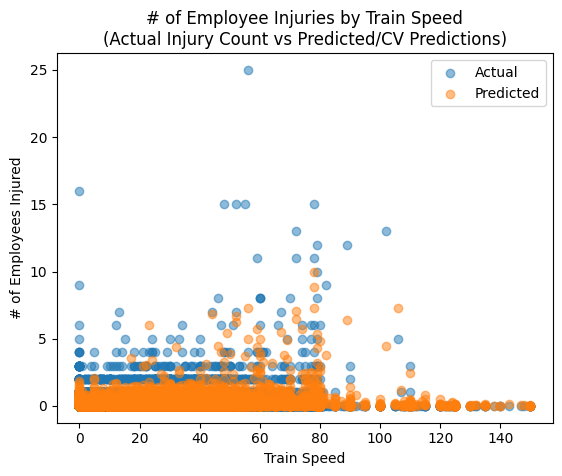

In [76]:
plt.scatter('Train Speed','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter('Train Speed','cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Train Speed')
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Train Speed\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()

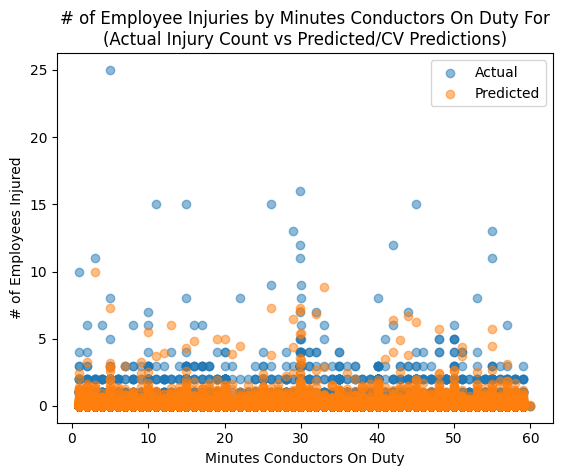

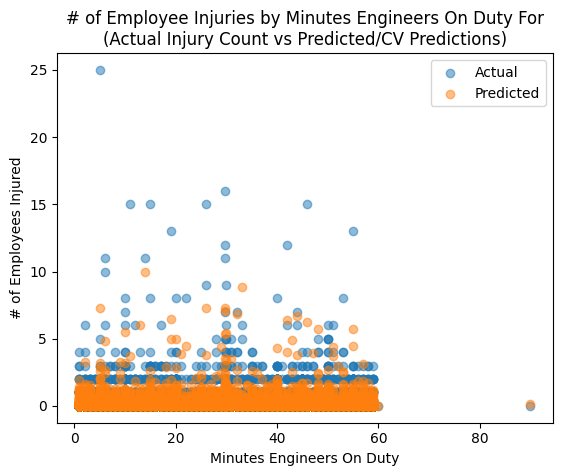

In [77]:
plt.scatter('Minutes Conductors On Duty','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter('Minutes Conductors On Duty','cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Minutes Conductors On Duty')
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Minutes Conductors On Duty For\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()

plt.scatter('Minutes Engineers On Duty','actual',data=cv_viz_df,label='Actual',alpha=.5)
plt.scatter('Minutes Engineers On Duty','cv_pred',data=cv_viz_df,label='Predicted',alpha=.5)
plt.xlabel('Minutes Engineers On Duty')
plt.ylabel('# of Employees Injured')
plt.title('# of Employee Injuries by Minutes Engineers On Duty For\n(Actual Injury Count vs Predicted/CV Predictions)')
plt.legend()
plt.show()